# Can Neural Network be used for feature selection?

In this notebook we'll use a breast cancer dataset to investigate if neural networks can be used for feature selection. We'll use the learned weights as
a proxy for feature importance, and see what happens with a super-simple one-layer network and how things get complicated when we add just one more
layer.

# Setup(s)

## Libraries setup

In [ ]:
#very common libraries, that we are for sure using
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Seed setup

In [ ]:
from numpy.random import seed
myseed = 0
seed(myseed)
tf.random.set_seed(myseed)

## Data setup

In [ ]:
#libraries for this block
import sklearn.datasets
from sklearn.model_selection import StratifiedShuffleSplit

# loading data
from sklearn.datasets import load_breast_cancer
bcancer = load_breast_cancer()
y = bcancer.target
X = pd.DataFrame(bcancer.data, columns=bcancer.feature_names)

## Adding a dud feature

We add a fake, meaningless ("dud") feature called "RANDOM_VALUES" that contains random values between zero and one. This feature has no meaning and if the feature selection process works well it should be filtered out (or at least highlighted as not interesting).

In [ ]:
from numpy.random import uniform
X['RANDOM_VALUES'] = np.random.uniform(size=X.shape[0])

## Normalizing

In [ ]:
# normalizing
X = (X - X.mean())/X.std()

# 1-Node Logistic Network

## Setup

In [ ]:
#libraries for this block
from keras.models import Sequential
from keras.layers import Dense

# Configuration
input_shape = (X.shape[1],) ## tuple that specifies the number of features
output_activation = 'sigmoid'
loss_function = 'binary_crossentropy'
extra_metrics = ['binary_accuracy']
optimizer_used = 'sgd' ##stochastic gradient descent
num_epochs = 100

# 1-node logistic neural network
model_1LN = Sequential()
model_1LN.add(Dense(1, activation=output_activation))

#compiling, training
model_1LN.compile(optimizer=optimizer_used, loss=loss_function, metrics=extra_metrics)
history = model_1LN.fit(X, y, epochs=num_epochs, validation_split=0.2, verbose=0)

## Verify training

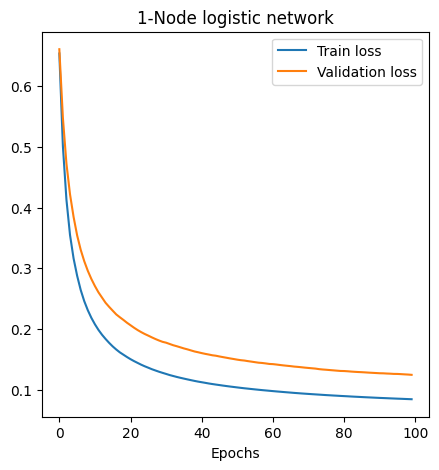

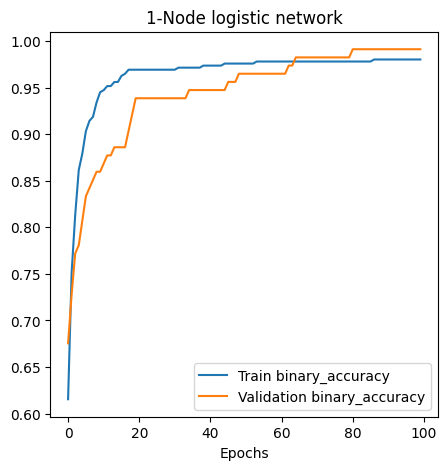

In [ ]:
def plot_history(h, title, target='loss'):
    plt.rcParams["figure.figsize"]=5,5
    plt.plot(h.history[target], label = "Train " + target)
    plt.plot(h.history['val_'+target], label = "Validation " + target)
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

plot_history(history, '1-Node logistic network', target = 'loss')
plot_history(history, '1-Node logistic network', target = 'binary_accuracy')

## Taking a look at the weights

In [ ]:
#extracting weights and biases from the first (and only) layer
weights = model_1LN.layers[0].get_weights()[0]
biases  = model_1LN.layers[0].get_weights()[1]

if True:
  #can you guess what this would print?
  print(weights.shape)
  print(biases.shape)

(31, 1)
(1,)


An image is worth a thousand words. Let's plot the weights.

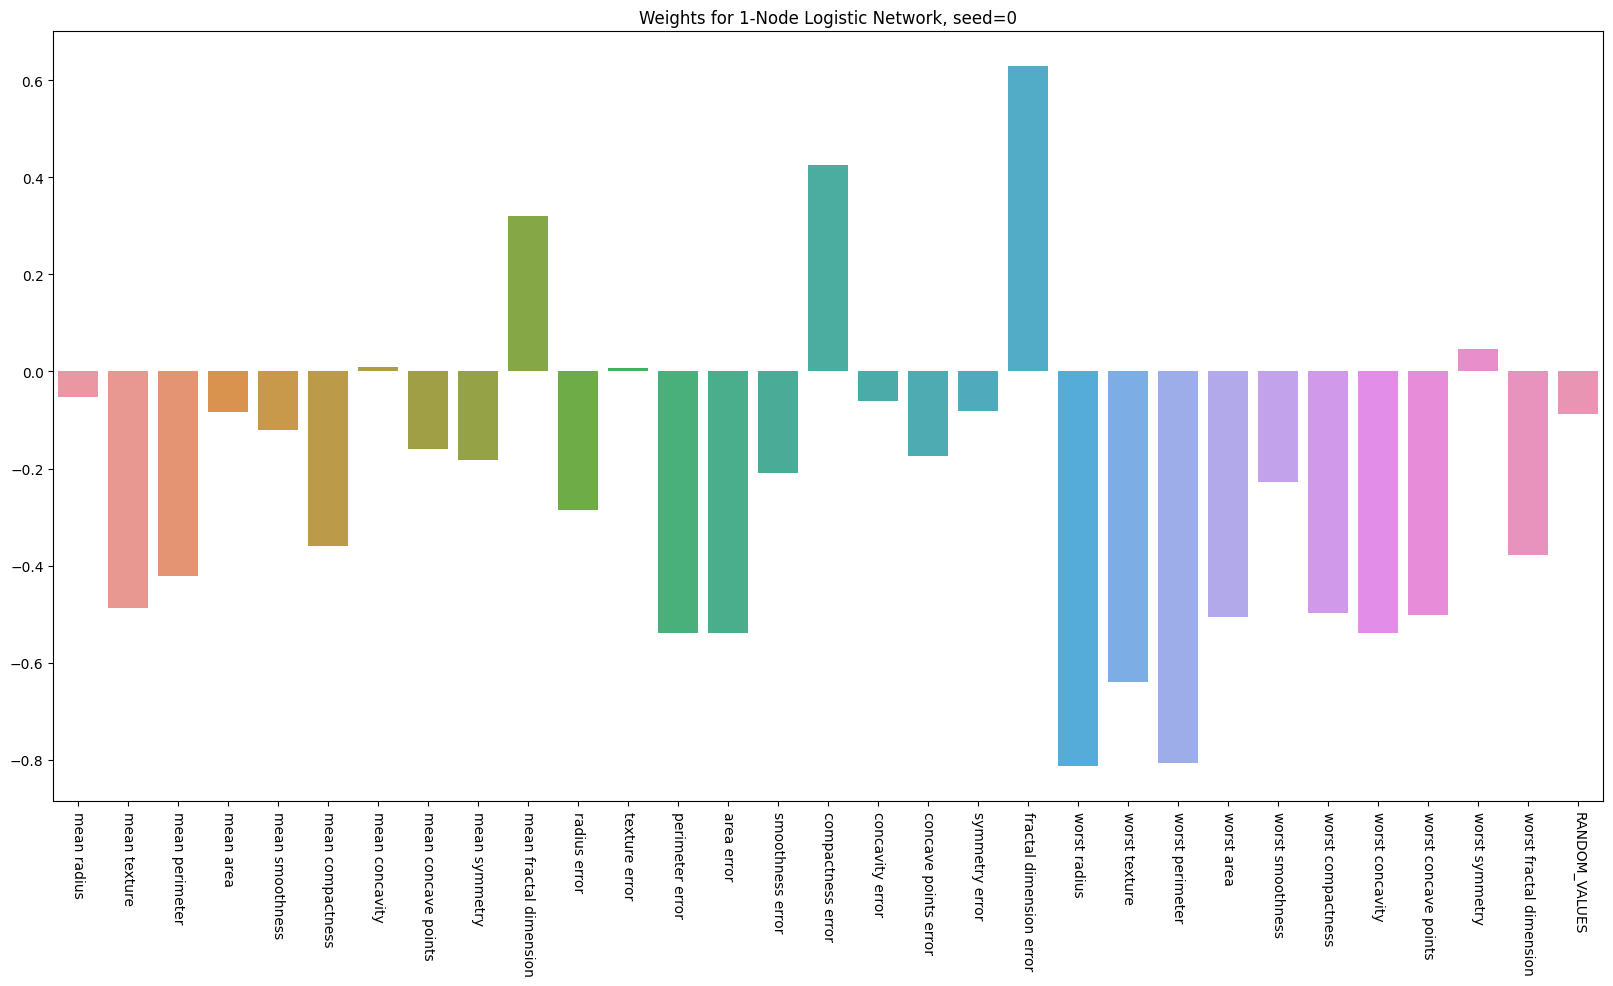

In [ ]:
#praparing data for the plot, we must have one column per feature, not per node, and properly named
mydata = pd.DataFrame(np.transpose(weights), columns = X.columns)

import seaborn as sb
plt.rcParams["figure.figsize"]=20,10
ax = sb.barplot(data=mydata)
ax.set(title='Weights for 1-Node Logistic Network, seed=' + str(myseed))
ax.set_xticklabels(labels = mydata.columns, rotation = -90)
plt.show()

## Same thing, 10 times (for statistics)

In [ ]:
for i in range(10):
  print('Doing iteration ' + str(i))

  # declaring a new model instance
  model_1LN = Sequential()
  model_1LN.add(Dense(1, activation=output_activation))

  #compiling, training
  model_1LN.compile(optimizer=optimizer_used, loss=loss_function, metrics=extra_metrics)
  history = model_1LN.fit(X, y, epochs=num_epochs, validation_split=0.2, verbose=0)

  #extracting weights from the current model
  weights_current = model_1LN.layers[0].get_weights()[0]

  #adding weights what we stored so far
  weights = np.concatenate((weights, weights_current), axis = 1)

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9


In [ ]:
if True:
  #can you guess what this would print?
  print(weights.shape)
  print(biases.shape)

(31, 11)
(1,)


Taking a look at the weights distribution

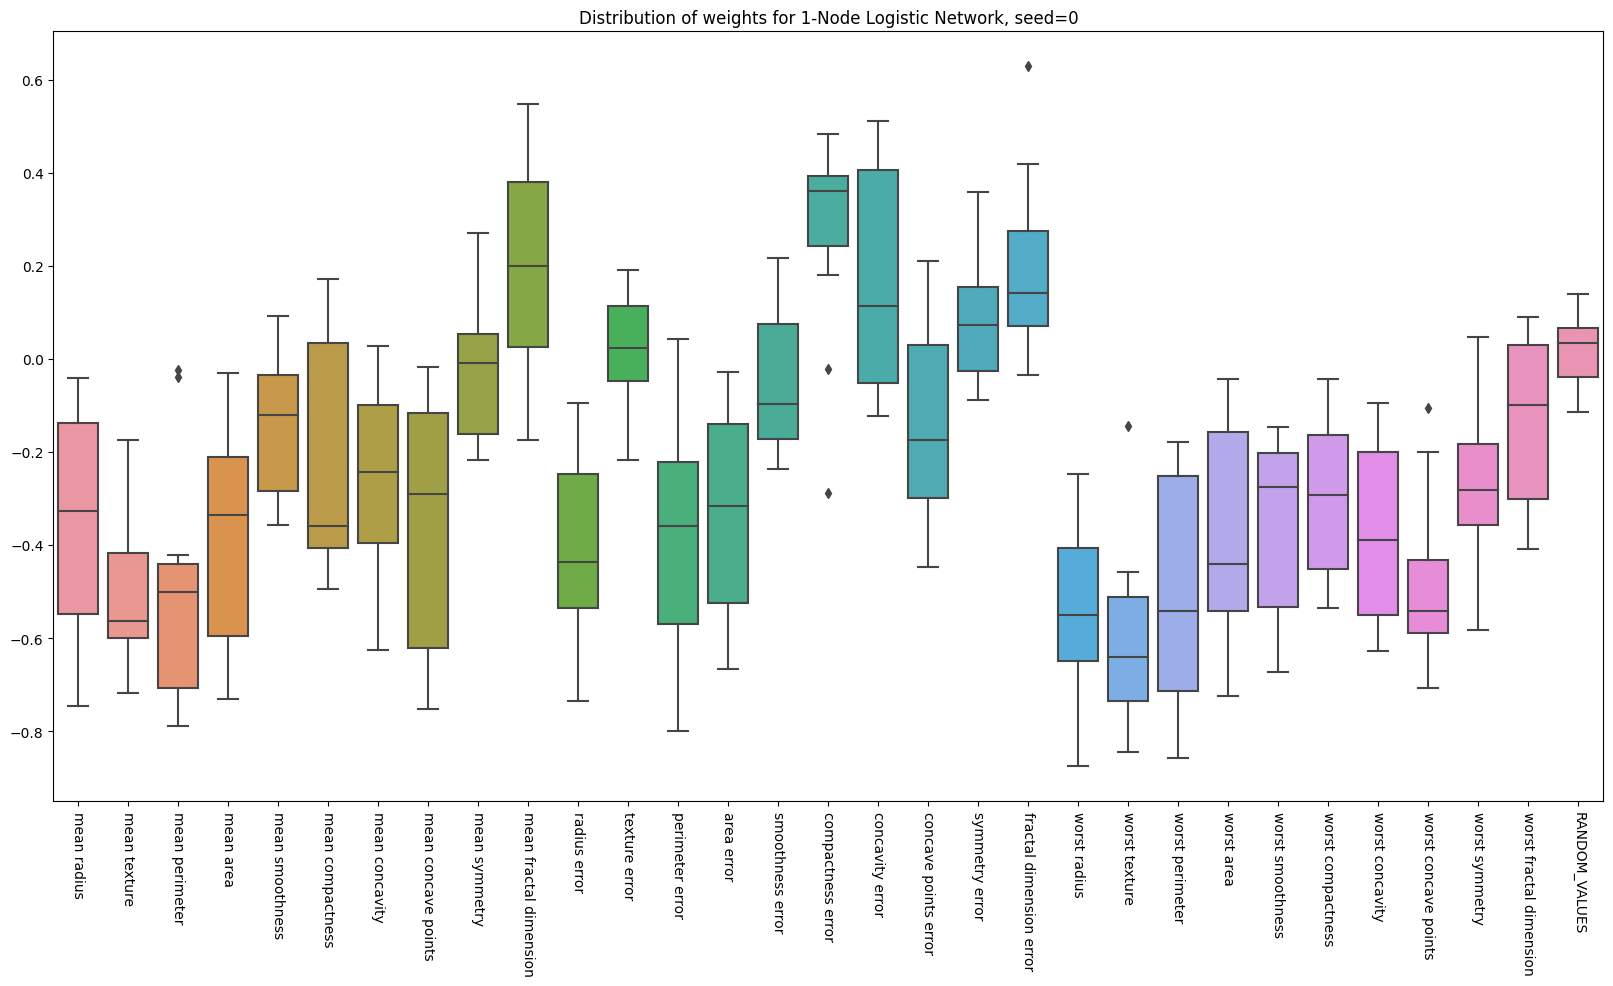

In [ ]:
#praparing data for the plot, we must have one column per feature, not per node, and properly named
mydata = pd.DataFrame(np.transpose(weights), columns = X.columns)

plt.rcParams["figure.figsize"]=20,10
ax = sb.boxplot(data=mydata)
ax.set(title='Distribution of weights for 1-Node Logistic Network, seed=' + str(myseed))
ax.set_xticklabels(labels = mydata.columns, rotation = -90)
plt.show()

Sorting by descending absolute values

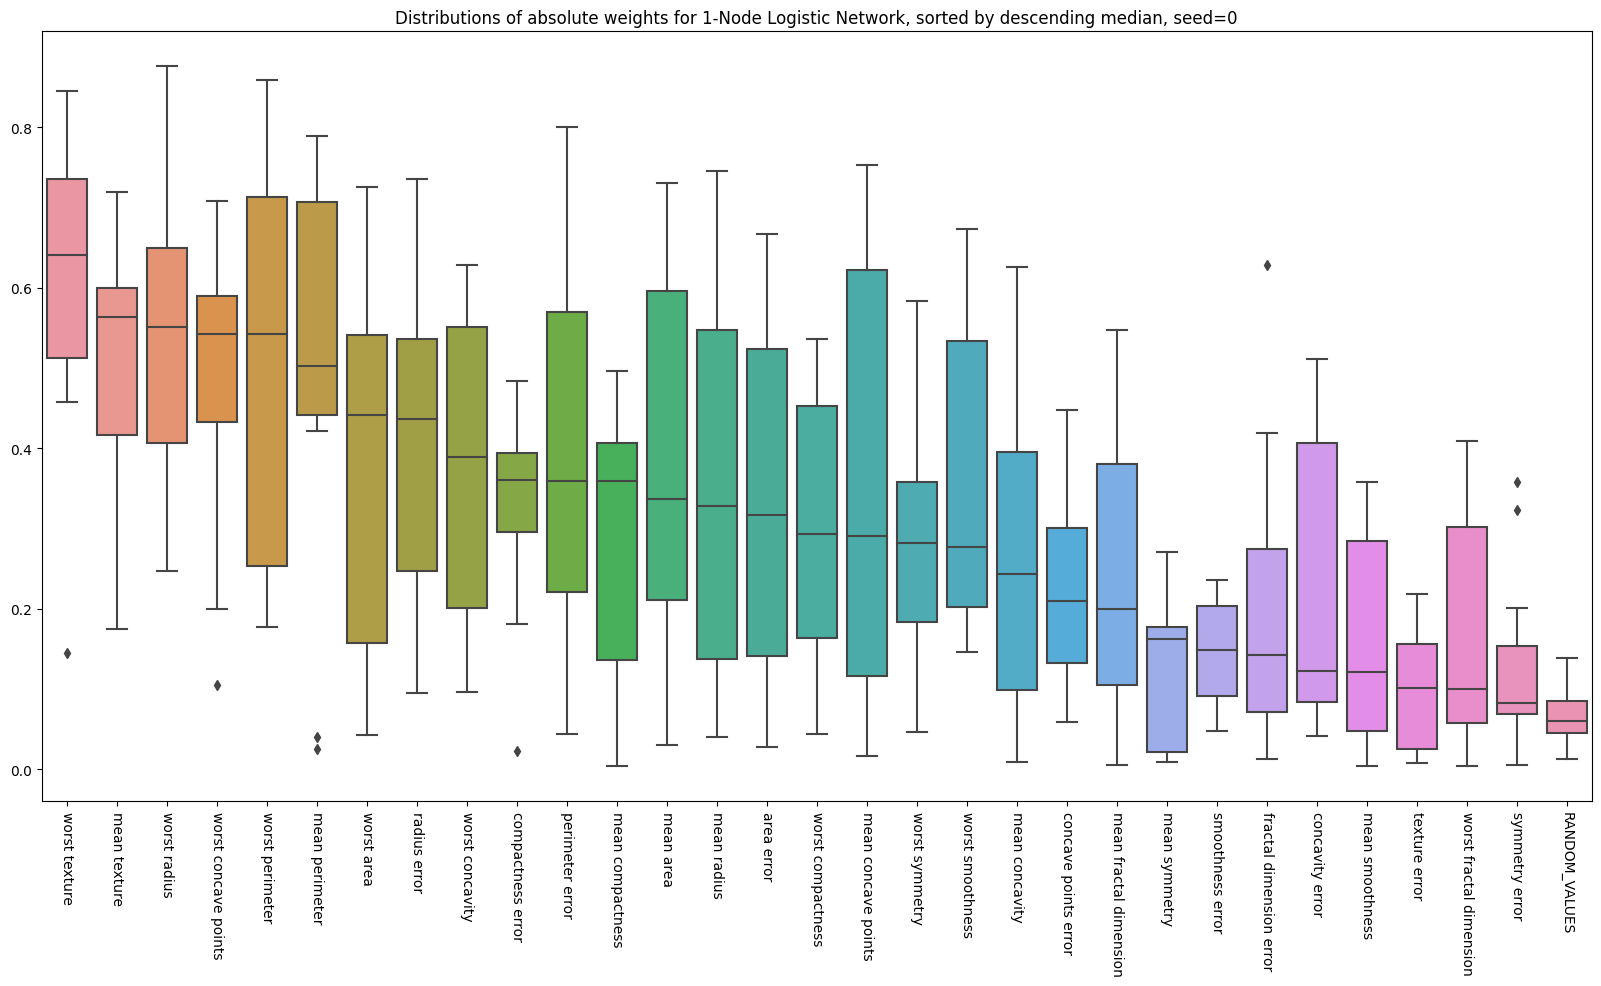

In [ ]:
#absolute values
mydata = mydata.abs()

#sorting by median
mydata = mydata.reindex(mydata.median().sort_values(ascending=False).index, axis=1)

#distribution plot
plt.rcParams["figure.figsize"]=20,10
ax = sb.boxplot(data=mydata)
ax.set(title='Distributions of absolute weights for 1-Node Logistic Network, sorted by descending median, seed=' + str(myseed))
ax.set_xticklabels(labels = mydata.columns, rotation = -90)
plt.show()

# Shallow (2 layers) neural network

Training

In [ ]:
# newtwork configuration
input_shape = (X.shape[1],) ## tuple that specifies the number of features
hidden_nodes = 16
hidden_activation = 'relu'
output_activation = 'sigmoid'
loss_function = 'binary_crossentropy'
extra_metrics = ['binary_accuracy']
optimizer_used = 'sgd' ##stochastic gradient descent
num_epochs = 100

# training
weights_1stLayer = None
weights_2ndLayer = None
for i in range(10):
  print('Doing iteration ' + str(i))

  # declaring a new model instance
  model_shallow = Sequential()
  model_shallow.add(Dense(units=hidden_nodes, input_shape=input_shape, activation=hidden_activation))
  model_shallow.add(Dense(1, activation=output_activation))

  # compiling, training
  model_shallow.compile(optimizer=optimizer_used, loss=loss_function, metrics=extra_metrics)
  history = model_shallow.fit(X, y, epochs=num_epochs, validation_split=0.2, verbose=0)

  # extracting weights from the current model
  weights_1stLayer_current = model_shallow.layers[0].get_weights()[0]
  weights_2ndLayer_current = model_shallow.layers[1].get_weights()[0]

  # adding weights what we stored so far
  if weights_1stLayer is None:
     weights_1stLayer = weights_1stLayer_current
     weights_2ndLayer = weights_2ndLayer_current
  else:
    weights_1stLayer = np.concatenate((weights_1stLayer, weights_1stLayer_current), axis = 1)
    weights_2ndLayer = np.concatenate((weights_2ndLayer, weights_2ndLayer_current), axis = 1)

Doing iteration 0
Doing iteration 1
Doing iteration 2
Doing iteration 3
Doing iteration 4
Doing iteration 5
Doing iteration 6
Doing iteration 7
Doing iteration 8
Doing iteration 9


In [ ]:
if False:
  #can you guess what this would print?
  print(weights_1stLayer.shape)
  print(weights_2ndLayer.shape)

Plot

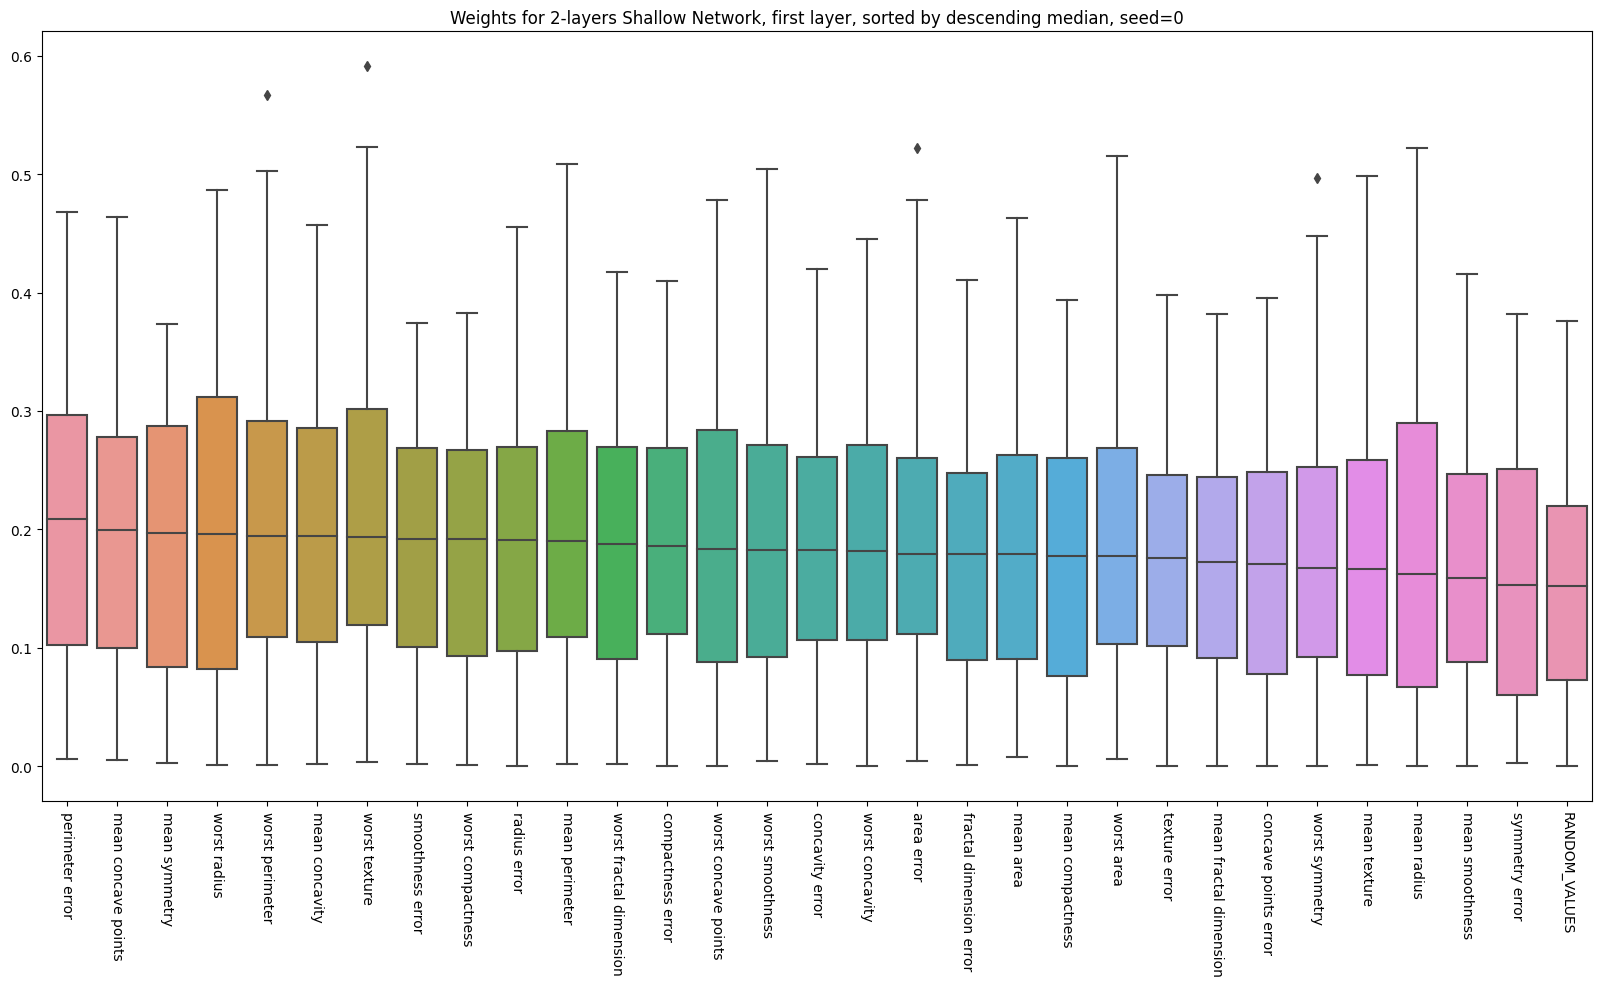

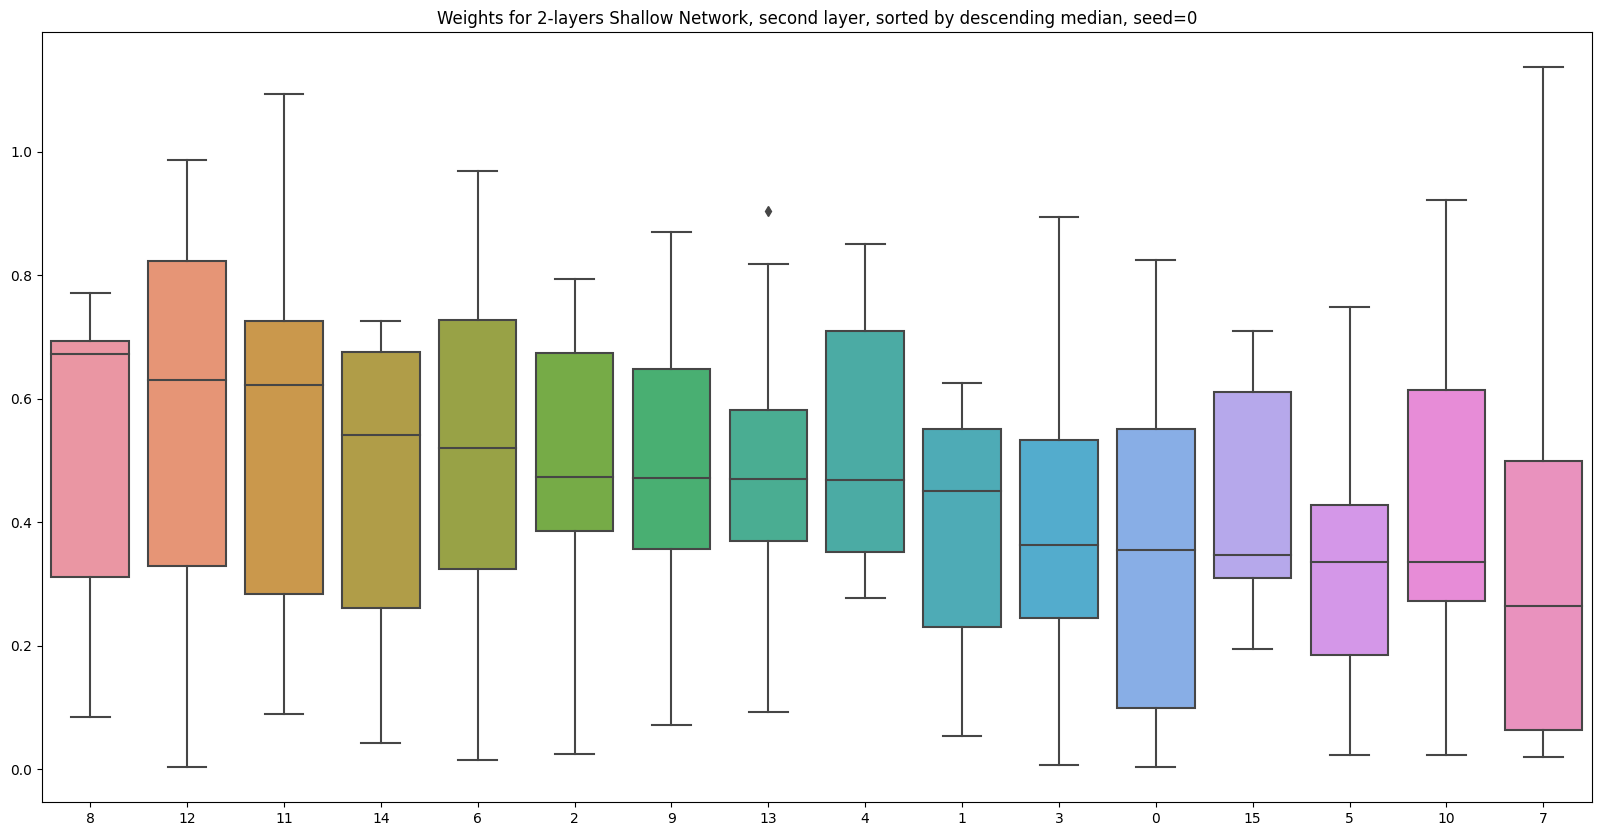

In [ ]:
#absolute values
mydata_1st = pd.DataFrame(np.transpose(weights_1stLayer), columns = X.columns).abs()
mydata_2nd = pd.DataFrame(np.transpose(weights_2ndLayer)).abs() #no column names here, can you guess why?

#sorting by median
mydata_1st = mydata_1st.reindex(mydata_1st.median().sort_values(ascending=False).index, axis=1)
mydata_2nd = mydata_2nd.reindex(mydata_2nd.median().sort_values(ascending=False).index, axis=1)

#distribution plot, 1st layer
plt.rcParams["figure.figsize"]=20,10
ax = sb.boxplot(data=mydata_1st)
ax.set(title='Weights for 2-layers Shallow Network, first layer, sorted by descending median, seed=' + str(myseed))
ax.set_xticklabels(labels = mydata_1st.columns, rotation = -90)
plt.show()

#distribution plot, 2nd layer
ax = sb.boxplot(data=mydata_2nd)
ax.set(title='Weights for 2-layers Shallow Network, second layer, sorted by descending median, seed=' + str(myseed))
ax.set_xticklabels(labels = mydata_2nd.columns)
plt.show()

# TODO
investigate correlation betweeen weights in layer 1

## Shedding some light in the blackbox?

There are options to try and make some sense out of the weights of neural networks. This is however a rather advanced topic, still the subject of cutting-edge current scientific research.

We list here a few websites where you can start this journey, in case you're interested:

- [Variable importance in neural networks](https://www.r-bloggers.com/2013/08/variable-importance-in-neural-networks/) (an R blog)
- [Feature Importance with Neural Network](https://towardsdatascience.com/feature-importance-with-neural-network-346eb6205743) (a Python blog)
- [Nonparametric variable importanceusing an augmented neural network with multi-task learning](https://proceedings.mlr.press/v80/feng18a/feng18a.pdf) (scientific article, *International conference on machine learning*, 2018)
- [VtNet: A neural network with variable importance assessment](https://https://onlinelibrary.wiley.com/doi/abs/10.1002/sta4.325) (scientific article, *Stat*, 2020)
- [An accurate comparison of methods for quantifying variable importance in artificial neural networks using simulated data](https://https://www.sciencedirect.com/science/article/pii/S0304380004001565?via%3Dihub) (scientific article, *Ecological Modelling*, 2004)